## Check for Programmatic variations


In [17]:
import pandas as pd
import json

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Load both match files
match_files = {
    'Hacky': json.load(open('matches/matchesHacky.json', 'r')),
    'TransE': json.load(open('matches/HybridTransE_alpha_0.5.json', 'r')),
    'Distmult': json.load(open('matches/HybridDistmult_filtered.json', 'r')),
    'Sent_filtered2': json.load(open('matches/SentenceEmbedding_filterednew.json', 'r')),
    'Sent_filtered': json.load(open('matches/SentenceEmbedding_filtered.json', 'r')),
    'Node2vec': json.load(open('matches/HybridNode2vec_filtered.json', 'r')),
}

def extract_uuid(uri):
    return uri.split("/")[-1]

# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

 # Set pandas display options to use the full width of the notebook
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.expand_frame_repr', False)
    print(f"Combined Variation and Entity-Type Analysis for {match_type}:")
    print(variation_frame)
   

Matching Statistics for Hacky:
Number of matches in Hacky: 2658
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 497
Percentage Matched (%): 52.99

Combined Variation and Entity-Type Analysis for Hacky:
             variation_type             entity_type  Golden Standard Count  Matched Count  Matched (%)
0                 city_typo                 Address                     28             19    67.857143
1         country_expansion                 Address                     13              0     0.000000
2             postal_format                 Address                     27             26    96.296296
3       house_number_suffix                 Address                     34             32    94.117647
4       email_domain_change            ContactPoint                     49             29    59.183673
5                email_typo            ContactPoint                     53             27    50.943396
6                 name_typo  HealthcareOrganization       

In [11]:
variation_frame

,variation_type,entity_type,Golden Standard Count,Matched Count,Matched (%)
0,city_typo,Address,28,28,100.000000
1,country_expansion,Address,13,3,23.076923
2,postal_format,Address,27,27,100.000000
3,house_number_suffix,Address,34,34,100.000000
4,email_domain_change,ContactPoint,49,47,95.918367
5,email_typo,ContactPoint,53,53,100.000000
6,name_typo,HealthcareOrganization,5,5,100.000000
7,name_abbreviation,HealthcareOrganization,7,2,28.571429
8,email_typo,HealthcarePersonnel,316,316,100.000000
9,name_typo,Person,56,56,100.000000


In [12]:
# Find all golden standard matches that were NOT found by the last algorithm run in the loop
missed_rows = golden_standard[~golden_standard.index.isin(matched_rows.index)]

print(f"Number of missed matches: {len(missed_rows)}")
missed_rows.head()  # Show a sample

Number of missed matches: 152


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
4,603fa8f0-1549-4dee-830b-4d6d9575d095,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
14,5a8fe4b2-8ffd-4977-85b8-93b04d36c61a,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
20,929c8ac4-bf28-40fb-a8cb-2f6eee5e256e,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
32,f01688e4-b43b-4ab8-802b-7d666abb6f15,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
39,69259d81-2a2e-4ea7-9834-aeaf0f332bab,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands


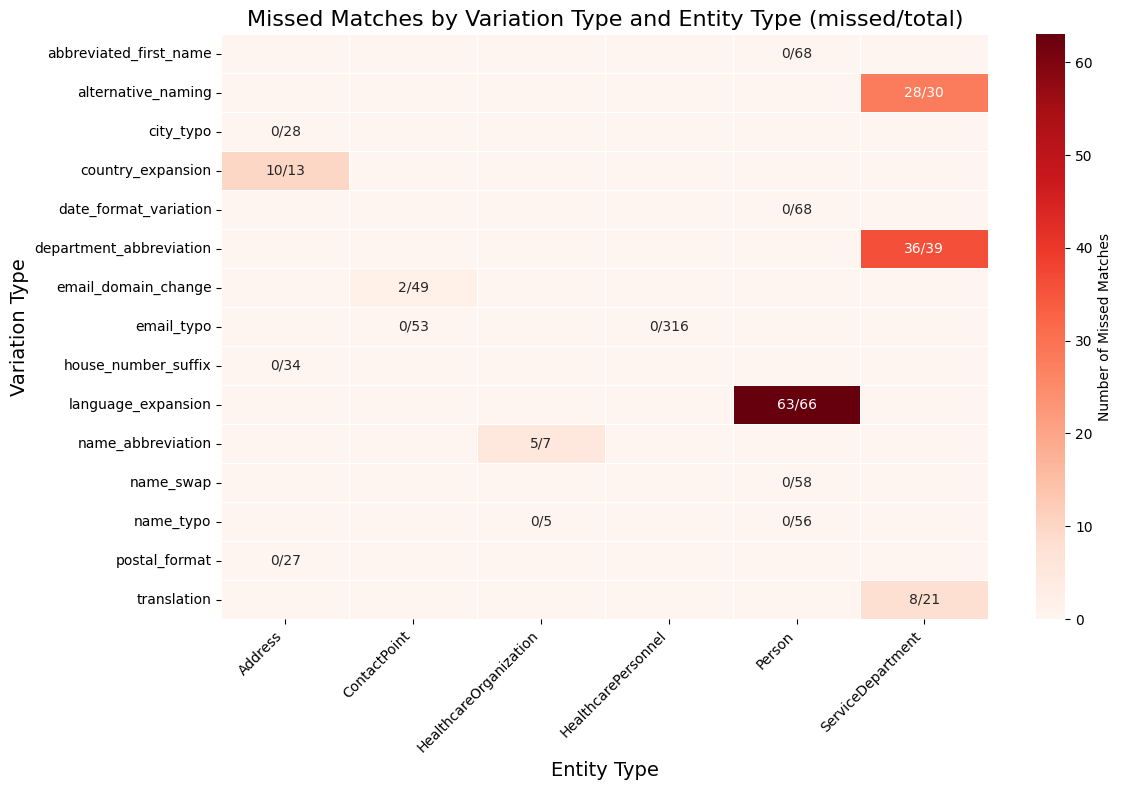

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate missed and total counts
missed_counts = missed_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

# Ensure both have the same index and columns
all_index = total_counts.index.union(missed_counts.index)
all_columns = total_counts.columns.union(missed_counts.columns)
missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

# Create annotation matrix like "missed/total"
annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
# Replace "0/0" with empty string for clarity
annot = annot.where(total_counts != 0, "")

plt.figure(figsize=(12, 8))
sns.heatmap(
    missed_counts, 
    annot=annot, 
    fmt="", 
    cmap="Reds", 
    linewidths=.5, 
    cbar_kws={'label': 'Number of Missed Matches'}
)
plt.title("Missed Matches by Variation Type and Entity Type (missed/total)", fontsize=16)
plt.ylabel("Variation Type", fontsize=14)
plt.xlabel("Entity Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [1]:
pip install karateclub

     ---------------------------------------- 0.0/64.5 kB ? eta -:--:--
     ---------------------------------------- 64.5/64.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/14.7 MB ? eta -:--:--
     -- ------------------------------------- 0.8/14.7 MB 17.0 MB/s eta 0:00:01
     -- ------------------------------------- 1.0/14.7 MB 22.0 MB/s eta 0:00:01
     ------ --------------------------------- 2.3/14.7 MB 16.2 MB/s eta 0:00:01
     -------- ------------------------------- 3.1/14.7 MB 20.1 MB/s eta 0:00:01
     -------- ------------------------------- 3.1/14.7 MB 20.1 MB/s eta 0:00:01
     --------- ------------------------------ 3.5/14.7 MB 12.3 MB/s eta 0:00:01
     -------------- ------------------------- 5.2/14.7 MB 17.6 MB/s eta 0:00:01
     -------------- ------------------------- 5.2/14.7 MB 17.6 MB/s eta 0:00:01
     ----------------- -----------

  DEPRECATION: python-louvain is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  DEPRECATION: karateclub is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.10.3 requires numpy>=1.23, but you have numpy 1.22.4 which is incompatible.
contourpy 1.3.2 requires numpy>=

In [ ]:
from karateclub import FirstOrderLINE